# Assignment 4: Customer Segmentation with Clustering

**Student Name:** Nash Gagliano

**Date:** 2/22/2026

---

## Assignment Overview

You've been hired as a data science consultant by a UK-based online gift retailer. They're spending the same amount on marketing to all customers regardless of value. Your task: segment their customer base using transaction data from 2009-2011, identify distinct customer groups, and provide actionable recommendations for each segment.

---

## Step 1: Import Libraries and Load Data

In [32]:
pip install pandas matplotlib seaborn scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [33]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Set random seed for reproducibility
np.random.seed(42)

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [34]:
# Load the Online Retail II dataset
# TODO: Load online_retail_II.csv from the data folder
df = pd.read_csv("data/online_retail_II.csv") # Replace with pd.read_csv()

# Display basic information
# TODO: Display the first few rows and basic info about the dataset
print(df.head())


print("\n" + "="*80)
print("CHECKPOINT: Verify dataset loaded correctly")
print(f"Dataset shape: {df.shape if df is not None else 'Not loaded'}")
print(f"Date range: [Check InvoiceDate column]")
print("="*80)

  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

CHECKPOINT: Verify dataset loaded correctly
Dataset shape: (1067371, 8)
Date range: [Check InvoiceDate column]


---
## Step 2: Aggregate Transaction Data to Customer-Level RFM Features

### Clean Transaction Data

Before aggregating to customer-level, clean the transaction data:
- Remove rows with missing Customer ID
- Remove returns (negative Quantity)
- Create TotalSpend column (Quantity × Price)
- Convert InvoiceDate to datetime

In [35]:
# Clean the data
# TODO: Remove missing Customer IDs
df = df.dropna(subset=['Customer ID'])

# TODO: Remove negative quantities (returns)
df = df[df['Quantity'] > 0]

# TODO: Create TotalSpend column
df['TotalSpend'] = df['Quantity'] * df['Price']

# TODO: Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], errors='coerce')

print("\n" + "="*80)
print("CHECKPOINT: After data cleaning")
print(f"Remaining transactions: {len(df) if df is not None else 'N/A'}")
print(f"Unique customers: {df['Customer ID'].nunique() if df is not None else 'N/A'}")
print("="*80)


CHECKPOINT: After data cleaning
Remaining transactions: 805620
Unique customers: 5881


### Calculate RFM Features for Each Customer

Create three features for each customer:
- **Recency**: Days since last purchase (use December 10, 2011 as reference date)
- **Frequency**: Total number of unique invoices
- **Monetary**: Total amount spent

In [36]:
# Set reference date for recency calculation
reference_date = pd.to_datetime('2011-12-10')

# TODO: For each Customer ID, calculate:
# - Recency: (reference_date - max(InvoiceDate)).days
# - Frequency: count of unique Invoice numbers
# - Monetary: sum of TotalSpend

rfm_df = rfm_df = df.groupby('Customer ID').agg(
    Recency = ('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency = ('Invoice', 'nunique'),
    Monetary = ('TotalSpend', 'sum')
).reset_index()  # Replace with aggregated DataFrame

print("\n" + "="*80)
print("CHECKPOINT: RFM Features Created")
if rfm_df is not None:
    print(f"Number of customers: {len(rfm_df)}")
    print(f"\nRFM Summary Statistics:")
    print(rfm_df.describe())
print("="*80)


CHECKPOINT: RFM Features Created
Number of customers: 5881

RFM Summary Statistics:
        Customer ID      Recency    Frequency       Monetary
count   5881.000000  5881.000000  5881.000000    5881.000000
mean   15314.674205   200.992858     6.287196    3017.076888
std     1715.429759   209.489651    13.012879   14734.128619
min    12346.000000     0.000000     1.000000       0.000000
25%    13833.000000    25.000000     1.000000     347.800000
50%    15313.000000    95.000000     3.000000     897.620000
75%    16797.000000   379.000000     7.000000    2304.180000
max    18287.000000   738.000000   398.000000  608821.650000


---
## Step 3: Standardize Features and Determine Optimal k

### Standardize RFM Features

K-means is sensitive to feature scale, so standardize features to mean=0, std=1

In [37]:
# TODO: Use StandardScaler to standardize Recency, Frequency, and Monetary
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']]) # Replace with scaled features

print("\n" + "="*80)
print("CHECKPOINT: Features Standardized")
if rfm_scaled is not None:
    print(f"Scaled features shape: {rfm_scaled.shape}")
    print(f"Mean of scaled features: {rfm_scaled.mean(axis=0)}")
    print(f"Std of scaled features: {rfm_scaled.std(axis=0)}")
print("="*80)


CHECKPOINT: Features Standardized
Scaled features shape: (5881, 3)
Mean of scaled features: [ 9.18232408e-17 -2.77886123e-17  2.41640107e-18]
Std of scaled features: [1. 1. 1.]


### Elbow Method: Test k from 2 to 10

Calculate inertia (within-cluster sum of squares) for different values of k

In [38]:
# TODO: Test k values from 2 to 10
# For each k:
#   - Train KMeans(n_clusters=k, random_state=42)
#   - Store inertia value'
from sklearn.cluster import KMeans

inertias = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)


print("\n" + "="*80)
print("CHECKPOINT: Elbow Method Calculated")
print(f"Tested k values: {list(k_range)}")
print("="*80)


CHECKPOINT: Elbow Method Calculated
Tested k values: [2, 3, 4, 5, 6, 7, 8, 9, 10]


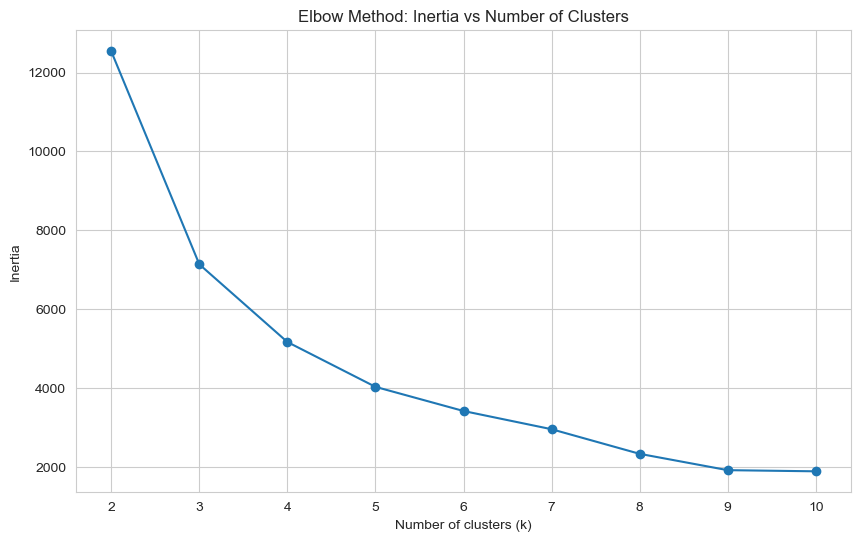

In [39]:
# TODO: Plot the elbow curve
import matplotlib.pyplot as plt

plt.figure()
plt.plot(k_range, inertias, marker='o', linestyle='-')
plt.title("Elbow Method: Inertia vs Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia")
plt.show()



### Silhouette Score Analysis

Calculate silhouette scores to validate cluster quality

In [40]:
# TODO: Calculate silhouette scores for k from 2 to 10
# For each k:
#   - Train KMeans
#   - Calculate silhouette_score(rfm_scaled, labels)

silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)

print("\n" + "="*80)
print("CHECKPOINT: Silhouette Scores Calculated")
print("="*80)


CHECKPOINT: Silhouette Scores Calculated


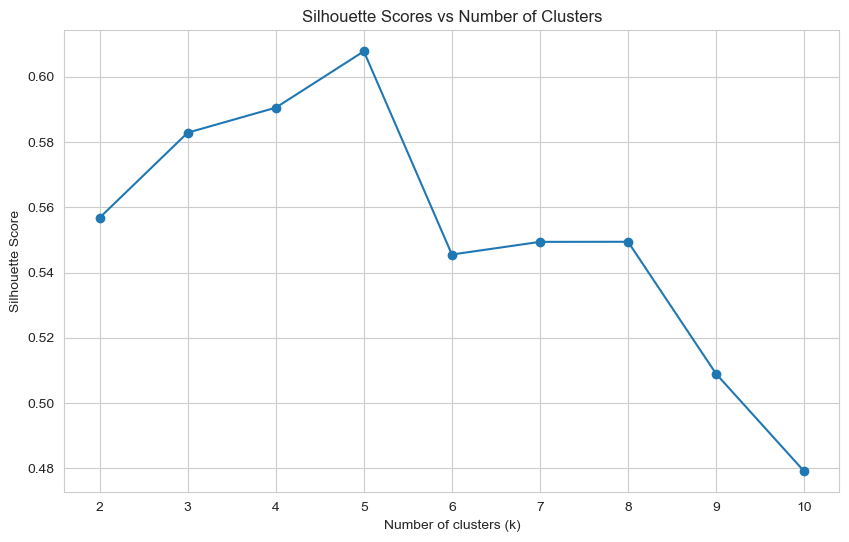

In [41]:
# TODO: Plot silhouette scores

plt.figure()
plt.plot(k_range, silhouette_scores, marker='o', linestyle='-')
plt.title("Silhouette Scores vs Number of Clusters")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()


### Select Optimal k

**Your k selection justification (write 2-3 sentences):**

I picked k = 4 because in the elbow plot the inertia starts leveling off after 4 clusters, so adding more doesn’t really improve things much. Also, the silhouette score is pretty high at 4, which means the clusters are well-separated. So 4 seems like a good balance between having enough detail and not overcomplicating stuff.

In [42]:
# TODO: Set your chosen k value
optimal_k = 4  # Replace with your chosen k (e.g., 4, 5, or 6)

print(f"Chosen k value: {optimal_k}")

Chosen k value: 4


---
## Step 4: Train K-Means Model and Visualize Segments

### Train Final K-Means Model

In [43]:
# TODO: Train KMeans with your optimal_k and random_state=42
kmeans = KMeans(n_clusters=optimal_k, random_state=42) # Replace with trained model

# TODO: Add cluster labels to rfm_df
# rfm_df['Cluster'] = ...
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled)


print("\n" + "="*80)
print("CHECKPOINT: K-Means Model Trained")
print(f"Number of clusters: {optimal_k}")
if 'Cluster' in rfm_df.columns:
    print(f"\nCluster sizes:")
    print(rfm_df['Cluster'].value_counts().sort_index())
print("="*80)


CHECKPOINT: K-Means Model Trained
Number of clusters: 4

Cluster sizes:
Cluster
0    3840
1    2002
2      35
3       4
Name: count, dtype: int64


### Visualize Customer Segments

Create a 2D scatter plot showing Frequency vs Monetary, colored by cluster

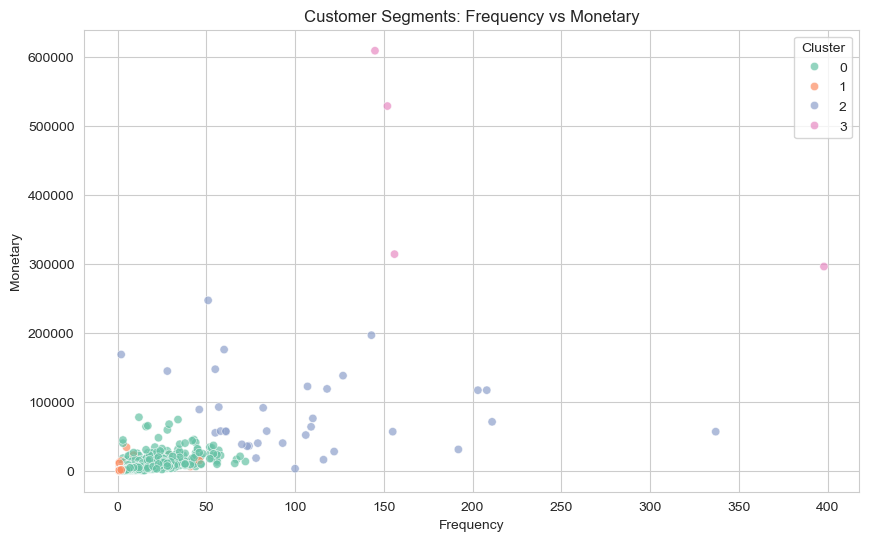

In [44]:
# TODO: Create scatter plot
# x-axis: Frequency
# y-axis: Monetary
# color: Cluster
# Include legend

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=rfm_df,
    x='Frequency',
    y='Monetary',
    hue='Cluster',
    palette='Set2',
    alpha=0.7
)
plt.title("Customer Segments: Frequency vs Monetary")
plt.xlabel("Frequency")
plt.ylabel("Monetary")
plt.legend(title='Cluster')
plt.show()


### Calculate Cluster Centers

Show the mean RFM values for each cluster

In [45]:
# TODO: Calculate mean Recency, Frequency, and Monetary for each cluster
cluster_summary = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()  # Replace with grouped DataFrame

print("\n" + "="*80)
print("CLUSTER CENTERS (Mean RFM Values)")
print("="*80)

# TODO: Display cluster_summary
print(cluster_summary)

print("="*80)


CLUSTER CENTERS (Mean RFM Values)
            Recency   Frequency       Monetary
Cluster                                       
0         66.417708    7.308333    3009.222829
1        462.584915    2.212288     765.563213
2         25.400000  103.742857   83086.079771
3          2.750000  212.750000  436835.792500


---
## Step 5: Interpret Segments and Provide Business Recommendations

### Segment 0: [Descriptive Name]

**Customer Profile (3-5 sentences):**

This group buys stuff every now and then. Their Recency is around 66 days, which means they’ve shopped recently but not super often. They make about 7 purchases on average and spend around $3,000 total, so they’re not the biggest spenders but they’re consistent. Compared to other segments, they’re more active than the inactive customers (Cluster 1), but not as crazy frequent or high-spending as the VIPs (Clusters 2 and 3). This group is solid because they bring steady revenue and could probably be convinced to spend a bit more with promotions.

In [46]:
# TODO: Calculate detailed statistics for Segment 0
# Show mean, median, min, max for R, F, M

segment_0_stats = rfm_df[rfm_df['Cluster'] == 0][['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'min', 'max'])
print("\n" + "="*80)
print("SEGMENT 0 STATISTICS (Recency, Frequency, Monetary)")
print("="*80)

print(segment_0_stats)
print("="*80)


SEGMENT 0 STATISTICS (Recency, Frequency, Monetary)
           Recency  Frequency      Monetary
mean     66.417708   7.308333   3009.222829
median   40.000000   5.000000   1350.475000
min       0.000000   1.000000      0.000000
max     372.000000  72.000000  77556.460000


### Segment 1: [Descriptive Name]

**Customer Profile (3-5 sentences):**

This group hasn’t shopped in a long time their Recency is about 462 days, so they basically haven’t been active recently. They only make around 2 purchases on average and spend about $765 total, which makes them the lowest spenders out of all the clusters. Compared to other segments, they’re much less engaged and don’t contribute much to revenue. These customers are probably not super loyal, but the company might try small incentives or reminder emails to bring them back.

In [47]:
# TODO: Calculate detailed statistics for Segment 1
segment_1_stats = rfm_df[rfm_df['Cluster'] == 1][['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'min', 'max'])

print("\n" + "="*80)
print("SEGMENT 1 STATISTICS (Recency, Frequency, Monetary)")
print("="*80)

print(segment_1_stats)

print("="*80)


SEGMENT 1 STATISTICS (Recency, Frequency, Monetary)
           Recency  Frequency      Monetary
mean    462.584915   2.212288    765.563213
median  430.000000   1.000000    381.045000
min     252.000000   1.000000      0.000000
max     738.000000  46.000000  34095.260000


### Segment 2: [Descriptive Name]

**Customer Profile (3-5 sentences):**

This group is really valuable to the company. Their Recency is super low, around 25 days, which means they shopped very recently. They buy a lot — about 104 purchases on average — and spend a huge amount of money, around $83,000, so they’re high-value customers. Compared to other segments, they’re way more engaged and bring in most of the revenue. The company should make sure to keep these customers happy with special deals, loyalty programs, or early access to new products.

In [48]:
# TODO: Calculate detailed statistics for Segment 2
segment_2_stats = rfm_df[rfm_df['Cluster'] == 2][['Recency', 'Frequency', 'Monetary']].agg(['mean', 'median', 'min', 'max'])

print("\n" + "="*80)
print("SEGMENT 2 STATISTICS (Recency, Frequency, Monetary)")
print("="*80)

print(segment_2_stats)

print("="*80)


SEGMENT 2 STATISTICS (Recency, Frequency, Monetary)
        Recency   Frequency       Monetary
mean       25.4  103.742857   83086.079771
median      3.0   84.000000   57446.440000
min         0.0    2.000000    2995.540000
max       372.0  337.000000  246973.090000


### [Continue for remaining segments]

This group is super loyal and spends the most by far. Their Recency is extremely low, around 3 days, meaning they shopped very recently. They make a ton of purchases — about 213 on average — and their total spend is massive, around $437,000. Compared to other segments, these customers are the top spenders and the most active. The company should treat them like VIPs with exclusive offers, priority service, or special events to keep them coming back.

---
## Business Recommendations

### Recommendation 1: [Title]

**Which segment(s) does this target?** [Segment name(s)]

**Recommendation (3-5 sentences):**

Since this group buys moderately often and spends a decent amount, the company could give them small loyalty discounts or bundle deals to encourage more purchases. Email campaigns or app notifications could be used to highlight these deals. Offering points for every purchase or a “buy 3, get 1 free” type of promotion could make them shop more frequently. This works because they already like the store and just need a little extra motivation to spend more.

### Recommendation 2: [Title]

**Which segment(s) does this target?** [Segment name(s)]

**Recommendation (3-5 sentences):**

This group hasn’t shopped in a long time and spends very little, so the company could try a win-back campaign to get them interested again. Sending personalized emails with discounts, special offers, or reminders about popular products could help bring them back. Social media ads targeting previous buyers could also work. The idea is to re-engage them without spending too much marketing budget since their potential spend is low. If even a few of them return, it adds extra revenue that would otherwise be lost.

### Recommendation 3: [Title]

**Which segment(s) does this target?** [Segment name(s)]

**Recommendation (3-5 sentences):**

This group spends the most and shops the most often, so the company should focus on keeping them super happy. Offering exclusive rewards, early access to new products, or special VIP-only discounts can make them feel valued. Personalized emails or a dedicated VIP app section could work well for communication. Since these customers already bring in most of the revenue, keeping them loyal is the best way to protect and grow profits. Making them feel special will encourage them to continue spending and maybe even recommend the store to friends.

---
## Step 6: Submit Your Work

Before submitting:
1. Make sure all code cells run without errors
2. Verify you have:
   - RFM features properly calculated
   - Elbow method and silhouette score visualizations
   - Written justification for your k selection
   - Customer segment scatter plot
   - Descriptive names and profiles for each segment
   - Three specific business recommendations
3. Check that all visualizations display correctly

Then push to GitHub:
```bash
git add .
git commit -m 'completed customer segmentation assignment'
git push
```

Submit your GitHub repository link on the course platform.